# GRU + Attention

Nous allons utiliser un modèle comprenant un réseau GRU ainsi qu'une couche d'attention.


## Préparer les données

In [1]:
import os
import sys
import torch
from torch.nn import functional as F
import numpy as np
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe
import pandas as pd
import torch
from torchtext import data
import random
# pour la reproductibilité
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(sequential=True,lower=True, tokenize = 'spacy', include_lengths=True, batch_first=True, fix_length=200)
LABEL = data.LabelField(dtype = torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
test_data, valid_data = test_data.split(random_state = random.seed(1234))

print(f'Taille des données train: {len(train_data)}')
print(f'Taille des données de validation: {len(valid_data)}')
print(f'Taille des données test: {len(test_data)}')

Taille des données train: 25000
Taille des données de validation: 7500
Taille des données test: 17500


In [2]:
MAX_VOCAB_SIZE = 50_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE, vectors=GloVe(name='6B', dim=100))
LABEL.build_vocab(train_data)

print(f"Nombre de tokens unique dans le TEXT: {len(TEXT.vocab)}") 
print(f"Nombre unique de LABEL: {len(LABEL.vocab)}")


# utilisation du GPU si possible 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
BATCH_SIZE = 32
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
device = device, sort_key=lambda x: len(x.text), repeat=False, shuffle=True)

Nombre de tokens unique dans le TEXT: 50002
Nombre unique de LABEL: 2


## Construire le modèle

Nous allons incorporer le mécanisme Attention dans notre modèle GRU. Dans ce nouveau modèle, nous utiliserons l'attention pour calculer le score d'alignement entre chacun des états cachés et le dernier état caché du GRU. 

Nous utiliserons `torch.bmm` pour la multiplication de la matrice par batch.

 Celui-ci est constitué d'une couche **embedding GloVe**, d'une couche **GRU**, puis d'une couche **Attention** et enfin de deux couches **fully connected**.

L'attention est calculée comme ceci:

$$
m_i = \tanh(W*\overrightarrow{h_i}\overleftarrow{h_i}+b)
$$ 

$$
a_i = \frac{m_i}{\sum_{k}^{n}m_k}
$$

$i$ représente le $i$ème mot du commentaire. $W$ est la matrice des poids et $b$ est un vecteur de biais.
L'attention consiste ici à prendre en compte un vecteur de contexte spécifique qui est une somme pondérée de tous les vecteurs d’état émis par le BiLSTM.

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

class AttentionModel(nn.Module):
    def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings, dropout):
        super(AttentionModel, self).__init__()


        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        self.weights = word_embeddings

        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        self.word_embeddings.weights = nn.Parameter(word_embeddings, requires_grad=False)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(embedding_length, hidden_size, dropout=dropout, bidirectional=True)
        self.W_s1 = nn.Linear(2*hidden_size, 350)
        self.W_s2 = nn.Linear(350, 30)
        self.fc_layer = nn.Linear(30*2*hidden_size, 2000)
        self.label = nn.Linear(2000, output_size)

    def attention_net(self, gru_output):

        attn_weight_matrix = self.W_s2(torch.tanh(self.W_s1(gru_output)))
        attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
        attn_weight_matrix = F.softmax(attn_weight_matrix, dim=2)

        return attn_weight_matrix


    def forward(self, input_sentences, batch_size=None):

        """ 
        Parameters
        ----------
        input_sentence: input_sentence taille = (batch_size, num_sequences)
        batch_size : default = None. Utilisé uniquement pour la prédiction sur une seule phrase après l'entraînement (batch_size = 1)
        
        Returns
        -------
        Sortie de la couche linéaire contenant les logits pour la classe positive & négative.
        
        """
        input_ = self.dropout(self.word_embeddings(input_sentences))
        input_ = input_.permute(1, 0, 2)
        if batch_size is None:
            h_0 = Variable(torch.zeros(2, self.batch_size, self.hidden_size).to(device))
        else:
            h_0 = Variable(torch.zeros(2, batch_size, self.hidden_size).cuda())

        output, h_n = self.gru(input_, h_0)
        output = output.permute(1, 0, 2)    
        attn_weight_matrix = self.attention_net(output)
        hidden_matrix = torch.bmm(attn_weight_matrix, output)
        fc_out = self.fc_layer(hidden_matrix.view(-1, hidden_matrix.size()[1]*hidden_matrix.size()[2]))
        fc_out1 = self.dropout(fc_out)
        logits = self.label(fc_out1)

        return logits

In [4]:
import torch.nn as nn
from torch.autograd import Variable
batch_size = 32
output_size = 2 # 2 labels 
hidden_size = 100 
embedding_length = 100 # dimension de GloVe word embeddings
word_embeddings = TEXT.vocab.vectors
vocab_size = len(TEXT.vocab)
dropout = 0.4

model = AttentionModel(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings, dropout)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Le modèle a {count_parameters(model):,} paramètres à entraîner')

Le modèle a 17,208,282 paramètres à entraîner


In [6]:
import torch.optim as optim

def optimiseur(model, lr=1e-4, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': weight_decay_rate},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': second_weight_decay_rate}]
    return optim.Adam(
        optimizer_grouped_parameters,
        lr=lr,
        eps=eps
    )

optimizer = optimiseur(model, lr=1e-4, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion =  F.cross_entropy

model = model.to(device)


def binary_accuracy(preds, y):
    """
    Retourne l'accuracy par batch
    """
    #arrondi la prédiction à l'entier le plus proche
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc


In [7]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        text = batch.text[0]
        target = batch.label 

        if (text.size()[0] is not batch_size):
            continue
        predictions = model(text)
        target = torch.autograd.Variable(target).long()
        loss = criterion(predictions, target)
        pred = torch.max(predictions, 1)[1].view(target.size()).data
        acc = binary_accuracy(pred.float(), target)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()       
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
      
    epoch_loss = 0
    epoch_acc = 0
      
    model.eval()
      
    with torch.no_grad():
      
        for batch in iterator:

            text = batch.text[0]
            
            if (text.size()[0] is not batch_size):
                continue
            target = batch.label 
            predictions = model(text)
            target = torch.autograd.Variable(target).long()
            loss = criterion(predictions, target )
            pred = torch.max(predictions, 1)[1].view(target.size()).data
            acc = binary_accuracy(pred.float(), target)
              
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

tloss = []
tacc = []
vloss = []
vacc = []

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    tloss.append(train_loss)
    tacc.append(train_acc) 
    scheduler.step()
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    vloss.append(valid_loss)
    vacc.append(valid_acc)   
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')



Epoch: 01 | Epoch Time: 0m 19s
	Train Loss: 0.629 | Train Acc: 64.09%
	 Val. Loss: 0.571 |  Val. Acc: 69.32%
Epoch: 02 | Epoch Time: 0m 19s
	Train Loss: 0.552 | Train Acc: 71.51%
	 Val. Loss: 0.512 |  Val. Acc: 73.90%
Epoch: 03 | Epoch Time: 0m 19s
	Train Loss: 0.510 | Train Acc: 74.53%
	 Val. Loss: 0.480 |  Val. Acc: 75.69%
Epoch: 04 | Epoch Time: 0m 19s
	Train Loss: 0.476 | Train Acc: 76.71%
	 Val. Loss: 0.454 |  Val. Acc: 77.75%
Epoch: 05 | Epoch Time: 0m 19s
	Train Loss: 0.451 | Train Acc: 78.38%
	 Val. Loss: 0.455 |  Val. Acc: 77.91%
Epoch: 06 | Epoch Time: 0m 20s
	Train Loss: 0.432 | Train Acc: 79.92%
	 Val. Loss: 0.424 |  Val. Acc: 79.45%
Epoch: 07 | Epoch Time: 0m 19s
	Train Loss: 0.417 | Train Acc: 80.74%
	 Val. Loss: 0.397 |  Val. Acc: 81.25%
Epoch: 08 | Epoch Time: 0m 19s
	Train Loss: 0.400 | Train Acc: 81.45%
	 Val. Loss: 0.414 |  Val. Acc: 80.57%
Epoch: 09 | Epoch Time: 0m 19s
	Train Loss: 0.391 | Train Acc: 82.13%
	 Val. Loss: 0.386 |  Val. Acc: 82.29%
Epoch: 10 | Epoch T

On trouve une valeur d'accuracy d'environ 80% pour les données de validation.

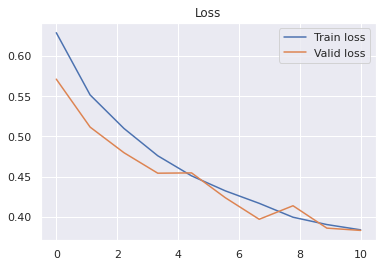

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
sns.set()

x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,tloss)
plt.plot(x,vloss)
plt.title("Loss")
plt.legend(["Train loss", "Valid loss"])

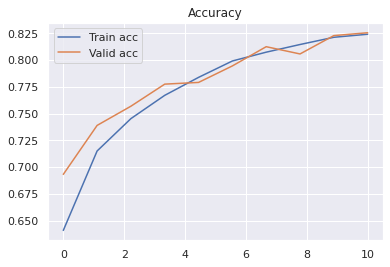

In [15]:
x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,tacc)
plt.plot(x,vacc)
plt.title("Accuracy")
plt.legend(["Train acc", "Valid acc"])

## Test

On teste le modèle sur notre jeu de données test.

In [16]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.390 | Test Acc: 82.78%


In [18]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    length_tensor = torch.LongTensor(length)
    #prediction = model(tensor, 1)
    
    prediction = model(tensor,1)
    if (prediction[0][1].item() > 0.5):
        print ("Sentiment: Positive")
    else:
        print ("Sentiment: Negative")


predict_sentiment(model, "this film is not good ")

Sentiment: Negative


In [19]:
predict_sentiment(model, "This film is amazing good ")

Sentiment: Positive


In [20]:
predict_sentiment(model, "This film is terrible ")

Sentiment: Negative


On remarque que contrairement aux modèles précédents ce modèle prend en compte la négation.

## Références

 - [Text-Classification-Pytorch](https://github.com/prakashpandey9/Text-Classification-Pytorch/blob/master/models/LSTM_Attn.py)
 - [NLP at IEST 2018: BiLSTM-Attention and LSTM-Attention via Soft
Voting in Emotion Classification](https://www.aclweb.org/anthology/W18-6226/)